# User Guide

SPFlow is an open-source functional-oriented Python package for Probabilistic Circuits (PCs) with ready-to-use implementations for Sum-Product Networks (SPNs). PCs are a class of powerful deep probabilistic models - expressible as directed acyclic graphs - that allow for tractable querying. This library provides routines for creating, learning, manipulating and interacting with PCs and is highly extensible and customizable.

## Create Toy Dataset

To demonstrate and visualize the main features of the library, we first create a 2D toy dataset with three Gaussian clusters, corresponding to labels 0, 1, and 2.
The dataset is created with an imbalance. Therefore, class 0 has 200 datapoints, class 1 400 datapoints and class 2 600 datapoints, for a total of 1,200 data points.

Dataset successfully created.
Shape of dataset: torch.Size([1200, 2])
Shape of labels: torch.Size([1200])
First 5 samples:
tensor([[-2.2949, -1.4371],
        [ 3.9714, -2.4763],
        [ 0.6340,  2.2905],
        [-3.4388, -1.8580],
        [-3.9820, -1.2865]])
Corresponding labels:
tensor([1, 2, 0, 1, 1])
1
(1200, 2)
Toy Data


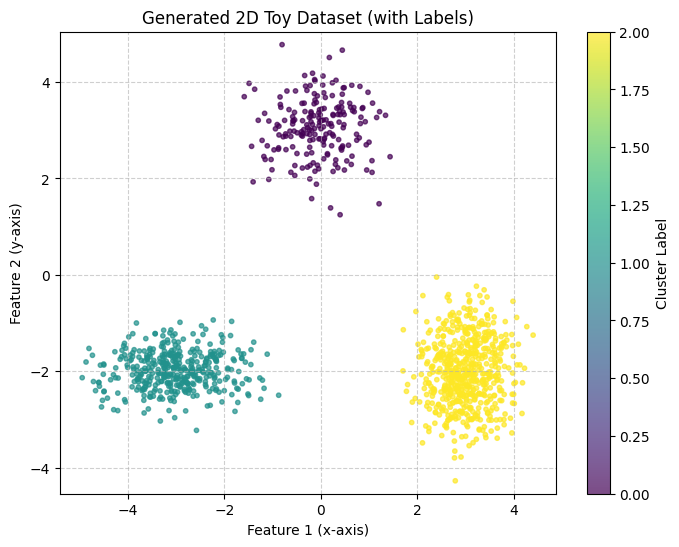

In [32]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Define the parameters for our dataset ---

n_points_per_cluster = 200

means = torch.tensor([
    [0.0, 3.0],  # Cluster 0
    [-3.0, -2.0],  # Cluster 1
    [3.0, -2.0]  # Cluster 2
])

stds = torch.tensor([
    [0.6, 0.6],
    [0.8, 0.4],
    [0.5, 0.7]
])

# --- 2. Generate the data and labels ---

all_clusters = []
all_labels = []

for i in range(means.shape[0]):
    samples = (torch.randn(n_points_per_cluster * (i + 1), 2) * stds[i]) + means[i]
    labels = torch.full((n_points_per_cluster * (i + 1),), i, dtype=torch.long)  # label = cluster index
    all_clusters.append(samples)
    all_labels.append(labels)

# Concatenate all data and labels
dataset = torch.cat(all_clusters)
labels = torch.cat(all_labels)

# --- 3. Shuffle dataset and labels together ---

shuffled_indices = torch.randperm(dataset.shape[0])
dataset = dataset[shuffled_indices]
labels = labels[shuffled_indices]

# --- 4. Display some info ---

print("Dataset successfully created.")
print(f"Shape of dataset: {dataset.shape}")
print(f"Shape of labels: {labels.shape}")
print("First 5 samples:")
print(dataset[:5])
print("Corresponding labels:")
print(labels[:5])

# --- 5. Visualize the labeled dataset ---

data_np = dataset.cpu().numpy()
labels_np = labels.cpu().numpy()


def plot_scatter(data_list, title=None, labels=None, label_list=None):
    colors = ["blue", "red", "yellow", "green"]
    plt.figure(figsize=(8, 6))
    for idx, data in enumerate(data_list):
        print(len(data_list))
        print(data.shape)
        print(label_list[idx])
        if labels is not None and len(data_list) == 1:
            plt.scatter(data[:, 0], data[:, 1], c=labels, cmap="viridis", s=10, alpha=0.7)
            plt.colorbar(label='Cluster Label')
        else:
            plt.scatter(data[:, 0], data[:, 1], c=colors[idx], s=10, alpha=0.7, label=label_list[idx])
            plt.legend()

    plt.title(title)
    plt.xlabel('Feature 1 (x-axis)')
    plt.ylabel('Feature 2 (y-axis)')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.axis('equal')
    #plt.colorbar(label='Cluster Label')

    plt.show()


plot_scatter([data_np], title='Generated 2D Toy Dataset (with Labels)', labels=labels_np, label_list=['Toy Data'])



## Model Configuration
The circuits you create with this library are modular. 

All modules share the same base structure. Each module is defined by its number of output features and output channels. You can think of output features as the number of nodes with different scopes in one layer. You can think of output channels as how many times a node with the same scope is repeated in a layer. This structure lets you define simple nodes (with a shape of (1, 1)), node vectors along the feature (N, 1) or channel (1, M) dimension, or full leaf layers (N, M). In many cases, using layers instead of single nodes is much faster and more memory-efficient.

Each module also has an input attribute that points to its input module. This lets you stack modules together in any order. 

Below, we will build a simple Sum-Product Network by stacking leaf, product, and sum layers.

In [33]:
from spflow.modules.leaves import Normal
from spflow.modules.sums import Sum
from spflow.modules.products import Product
from spflow.meta.data import Scope
from IPython.display import display, Image

scope = Scope([0, 1])

leaf_layer = Normal(scope=scope, out_channels=6)
product_layer = Product(inputs=leaf_layer)
spn = Sum(inputs=product_layer, out_channels=1)
spn

Sum(
  D=1, C=1, R=1, weights=(1, 6, 1, 1)
  (inputs): Product(
    D=1, C=6, R=1
    (inputs): Normal(D=2, C=6, R=1)
  )
)

Below is a visualization of the SPN defined above.
The number of output channels of a sum or leaf layer is equivalent to the number of nodes in that layer.
The number of nodes in a product layer is derived from the number of nodes in its input.

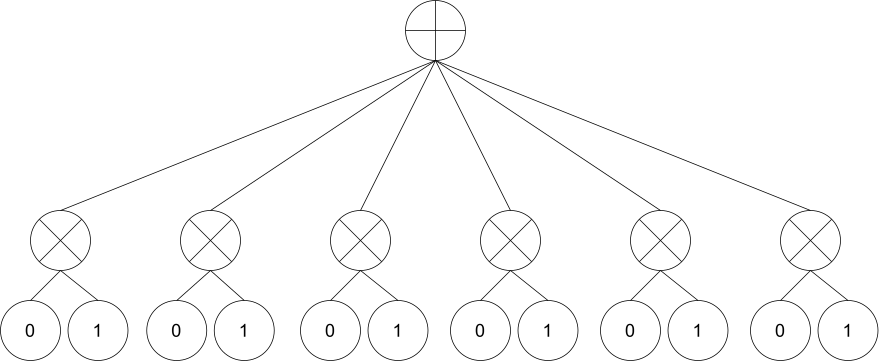

In [34]:
display(Image(filename='StandardSPN.png'))

Next, we can train the SPN, for example, using gradient descent.
The library already provides a method for training an SPN with gradient descent.
To do this, simply pass the module you want to train and the training parameters such as the number of epochs, learning rate, etc.


In [35]:
from spflow.learn import train_gradient_descent
from torch.utils.data import DataLoader, TensorDataset
import logging

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(name)s: %(message)s"
)

train_dataset = TensorDataset(dataset)
dataloader = DataLoader(train_dataset, batch_size=10)
train_gradient_descent(spn, dataloader, epochs=10, lr=0.1, verbose=True)

2025-12-18 17:42:49,898 [INFO] spflow.learn.gradient_descent: Epoch [0/10]: Loss: 3.075335741043091
2025-12-18 17:42:49,921 [INFO] spflow.learn.gradient_descent: Epoch [1/10]: Loss: 2.797783374786377
2025-12-18 17:42:49,943 [INFO] spflow.learn.gradient_descent: Epoch [2/10]: Loss: 2.7927746772766113
2025-12-18 17:42:49,965 [INFO] spflow.learn.gradient_descent: Epoch [3/10]: Loss: 2.797919750213623
2025-12-18 17:42:49,987 [INFO] spflow.learn.gradient_descent: Epoch [4/10]: Loss: 2.809295654296875
2025-12-18 17:42:50,009 [INFO] spflow.learn.gradient_descent: Epoch [5/10]: Loss: 2.6913177967071533
2025-12-18 17:42:50,031 [INFO] spflow.learn.gradient_descent: Epoch [6/10]: Loss: 2.6882402896881104
2025-12-18 17:42:50,053 [INFO] spflow.learn.gradient_descent: Epoch [7/10]: Loss: 2.6677887439727783
2025-12-18 17:42:50,075 [INFO] spflow.learn.gradient_descent: Epoch [8/10]: Loss: 2.6553187370300293
2025-12-18 17:42:50,096 [INFO] spflow.learn.gradient_descent: Epoch [9/10]: Loss: 2.64652085304

Once the SPN is trained, we can perform queries such as inference and sampling.
SPFlow uses internal dispatching so that a single query function can work across all module types.
For example, the log_likelihood method shown below can be used for every SPN model encountered throughout this guide.

In [36]:
ll = spn.log_likelihood(dataset)
ll

tensor([[[[-3.2330]]],


        [[[-3.5693]]],


        [[[-4.1290]]],


        ...,


        [[[-1.9199]]],


        [[[-3.0639]]],


        [[[-1.7952]]]], grad_fn=<ViewBackward0>)

Finally, we can visualize the training results on our toy dataset.

<>:29: SyntaxWarning: invalid escape sequence '\m'
<>:29: SyntaxWarning: invalid escape sequence '\m'
/var/folders/t3/57fhyt955l9d7dby5dmlzs900000gn/T/ipykernel_65171/2429085685.py:29: SyntaxWarning: invalid escape sequence '\m'
  plt.colorbar(contour, label='Log-Likelihood $LL(\mathbf{x})$')


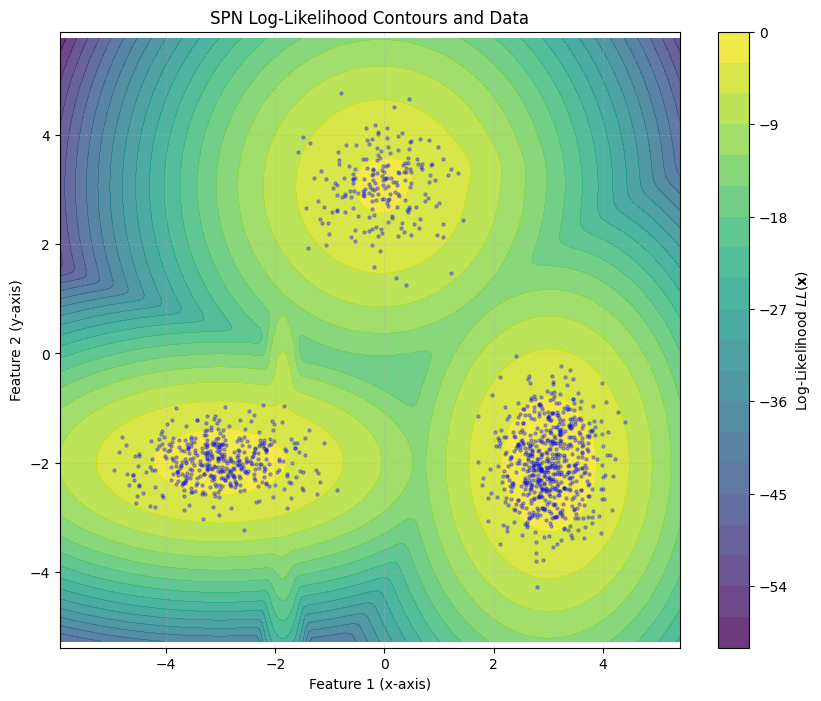

In [37]:


data_np = dataset.cpu().numpy()


def plot_contour(data, spn):
    # Define the boundaries of the plot with a small padding
    x_min, x_max = data_np[:, 0].min() - 1, data_np[:, 0].max() + 1
    y_min, y_max = data_np[:, 1].min() - 1, data_np[:, 1].max() + 1

    # Create a grid of points
    grid_resolution = 200
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, grid_resolution),
                         np.linspace(y_min, y_max, grid_resolution))

    # Stack the grid points into a format our function can accept: [n_points, 2]
    grid_points = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
    ll = spn.log_likelihood(grid_points)
    # Reshape the LL values to match the grid shape for plotting
    Z = ll.detach().cpu().numpy().reshape(xx.shape)

    # --- 6. Visualize the Data and Log-Likelihood Contours ---

    plt.figure(figsize=(10, 8))

    # Plot the filled contour map of the log-likelihood
    # Higher values (brighter colors) mean the model thinks data is more likely there
    contour = plt.contourf(xx, yy, Z, levels=20, cmap='viridis', alpha=0.8)

    # Add a color bar to show the LL scale
    plt.colorbar(contour, label='Log-Likelihood $LL(\mathbf{x})$')

    # Overlay the scatter plot of the actual data points
    # We make them semi-transparent and small to see the density and contours
    plt.scatter(data_np[:, 0], data_np[:, 1], s=5, alpha=0.3, c='blue')

    # Add titles and labels
    plt.title('SPN Log-Likelihood Contours and Data')
    plt.xlabel('Feature 1 (x-axis)')
    plt.ylabel('Feature 2 (y-axis)')
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.axis('equal')  # Ensures the scaling is the same on both axes
    plt.show()


plot_contour(data_np, spn)

## Temporary Method Replacement

SPFlow supports temporarily substituting module methods. For example, you can replace the sum operation in `Sum` with a custom implementation for a single call graph.


In [38]:
import torch
from spflow.modules.sums import Sum
from spflow.modules.products import Product
from spflow.modules.leaves import Normal
from spflow.meta import Scope
from spflow.utils import replace

torch.manual_seed(1)

# Create a probabilistic circuit: Product(Sum(Product(Normal)))
scope = Scope([0, 1])
normal = Normal(scope=scope, out_channels=4)
inner_product = Product(inputs=normal)
sum_module = Sum(inputs=inner_product, out_channels=1)
root_product = Product(inputs=sum_module)

# Create test data
data = torch.randn(3, 2)

# Normal inference
log_likelihood_original = root_product.log_likelihood(data).flatten()
print(f"Original log-likelihood: {log_likelihood_original}")

# Define a custom log_likelihood for Sum modules
def max_ll(self, data, cache=None):
    ll = self.inputs.log_likelihood(data, cache=cache).unsqueeze(3)
    weighted_lls = ll + self.log_weights.unsqueeze(0)
    return torch.max(weighted_lls, dim=self.sum_dim + 1)[0]

# Temporarily replace Sum.log_likelihood with custom implementation
with replace(Sum.log_likelihood, max_ll):
    log_likelihood_custom = root_product.log_likelihood(data).flatten()
    print(f"Custom log-likelihood:   {log_likelihood_custom}")

# Original method is automatically restored
log_likelihood_restored = root_product.log_likelihood(data).flatten()
print(f"Restored log-likelihood: {log_likelihood_restored}")



Original log-likelihood: tensor([-1.2842, -2.8750, -7.2442], grad_fn=<ViewBackward0>)
Custom log-likelihood:   tensor([-1.4334, -3.5256, -7.9031], grad_fn=<ViewBackward0>)
Restored log-likelihood: tensor([-1.2842, -2.8750, -7.2442], grad_fn=<ViewBackward0>)


## Automatic Model creation
Besides creating an SPN manually by stacking layers, it is also possible to use algorithms to automatically construct the SPN architecture. This can make it easier to start using SPNs.

###  Rat-SPN
The Rat-SPN algorithm builds a deep network structure by recursively partitioning the features (variables) into random subsets and alternating between sum and product layers.
Below, we set up a Rat-SPN by defining its structure and parameters.

In [39]:
from spflow.modules.rat.rat_spn import RatSPN

depth = 1
n_region_nodes = 3
num_leaves = 2
num_repetitions = 2
n_root_nodes = 1
num_feature = 2

scope = Scope(list(range(0, num_feature)))

rat_leaf_layer = Normal(scope=scope, out_channels=num_leaves, num_repetitions=num_repetitions)
rat = RatSPN(
    leaf_modules=[rat_leaf_layer],
    n_root_nodes=n_root_nodes,
    n_region_nodes=n_region_nodes,
    num_repetitions=num_repetitions,
    depth=depth,
    outer_product=True,
    split_mode=SplitMode.consecutive(),
)
print(rat.to_str())

RatSPN [D=1, C=1, R=2] → scope: 0-1
└─ RepetitionMixingLayer [D=1, C=1] [weights: (1, 1, 2)] → scope: 0-1
   └─ Sum [D=1, C=1] [weights: (1, 4, 1, 2)] → scope: 0-1
      └─ OuterProduct [D=1, C=4] → scope: 0-1
         └─ SplitConsecutive [D=2, C=2] → scope: 0-1
            └─ Factorize [D=2, C=2] → scope: 0-1
               └─ Normal [D=2, C=2] → scope: 0-1


Here is a visualization of the architecture we just created.

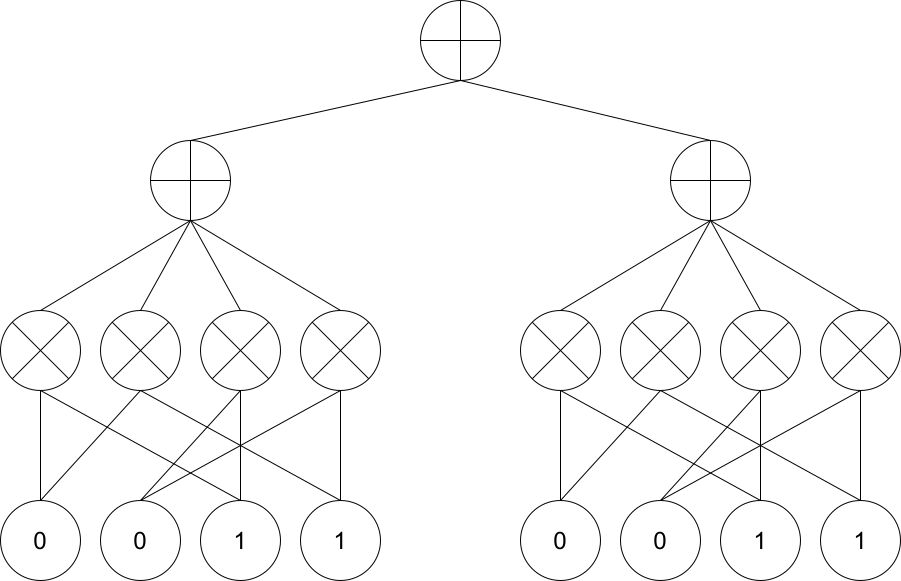

In [40]:
display(Image(filename='Rat_SPN.png'))

In [41]:
ll = rat.log_likelihood(dataset)
ll

tensor([[[[ -5.4888]]],


        [[[-14.4096]]],


        [[[ -4.4564]]],


        ...,


        [[[ -9.1111]]],


        [[[-15.1992]]],


        [[[-14.0941]]]], grad_fn=<ViewBackward0>)

We can again train this model using the provided gradient descent method. 

In [42]:
train_gradient_descent(rat, dataloader, epochs=20, lr=0.1)

To verify that the training worked properly, we can visualize the log-likelihoods of the trained model.

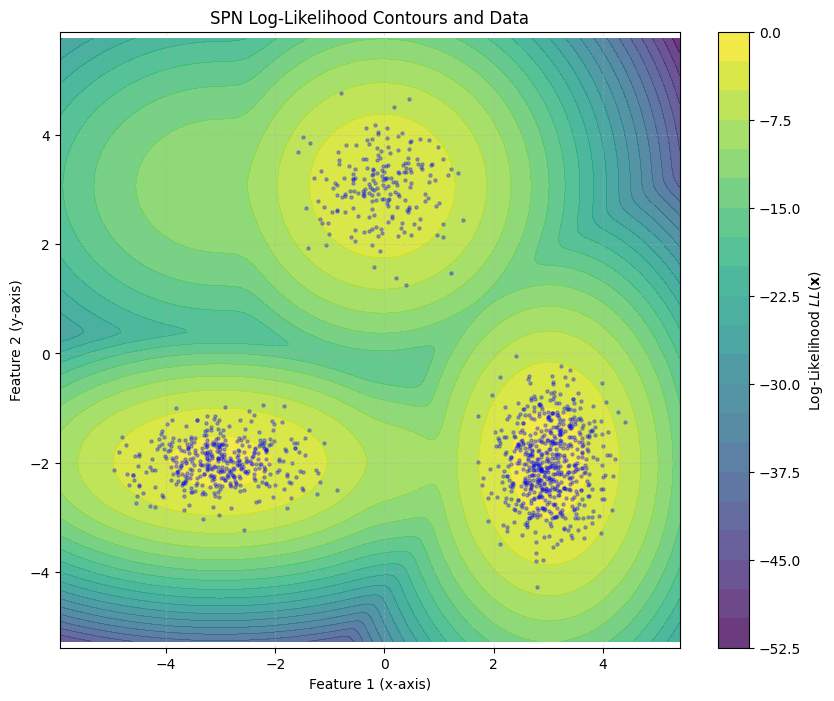

In [43]:
data_np = dataset.cpu().numpy()
plot_contour(data_np, rat)

Of course, computing log-likelihoods is not the only thing the model can do.
Below is a visualization of samples drawn from the trained Rat-SPN.

2
(1200, 2)
Original Data
2
torch.Size([1500, 2])
Samples


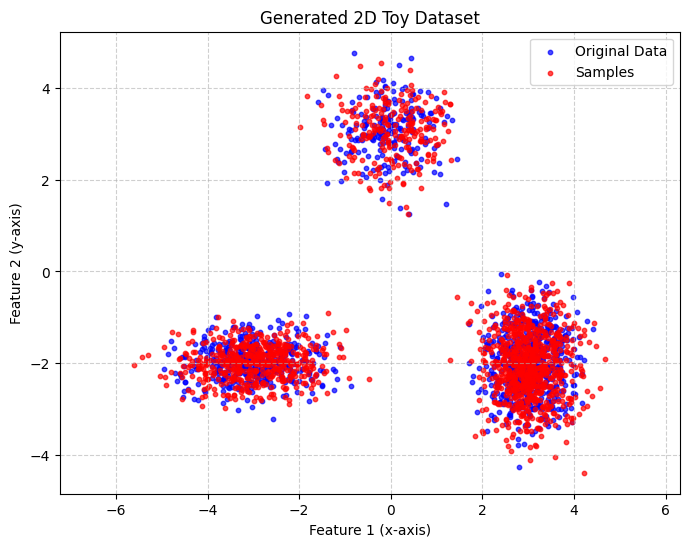

In [44]:
samples = spn.sample(num_samples=1500)
plot_scatter([data_np, samples], title='Generated 2D Toy Dataset', label_list=['Original Data', 'Samples'])


Up to now, we have focused only on generation, without considering the labels of the training instances.
Next, we will train a second Rat-SPN for classification.

In [45]:
import logging

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(name)s: %(message)s"
)

depth = 1
n_region_nodes = 3
num_leaves = 3
num_repetitions = 1
n_root_nodes = 3
num_feature = 2

scope = Scope(list(range(0, num_feature)))

rat_leaf_layer = Normal(scope=scope, out_channels=num_leaves, num_repetitions=num_repetitions)
rat_class = RatSPN(
    leaf_modules=[rat_leaf_layer],
    n_root_nodes=n_root_nodes,
    n_region_nodes=n_region_nodes,
    num_repetitions=num_repetitions,
    depth=depth,
    outer_product=True,
    split_mode=SplitMode.consecutive(),
)
train_dataset = TensorDataset(dataset.clone(), labels.clone())

dataloader_with_labels = DataLoader(train_dataset, batch_size=10)

train_gradient_descent(rat_class, dataloader_with_labels, epochs=100, lr=0.1, is_classification=True,
                       verbose=True)



2025-12-18 17:42:51,129 [INFO] spflow.learn.gradient_descent: Epoch [0/100]: Loss: 1.7290315628051758
2025-12-18 17:42:51,237 [INFO] spflow.learn.gradient_descent: Epoch [1/100]: Loss: 1.686271071434021
2025-12-18 17:42:51,342 [INFO] spflow.learn.gradient_descent: Epoch [2/100]: Loss: 1.7363437414169312
2025-12-18 17:42:51,442 [INFO] spflow.learn.gradient_descent: Epoch [3/100]: Loss: 1.745739459991455
2025-12-18 17:42:51,538 [INFO] spflow.learn.gradient_descent: Epoch [4/100]: Loss: 1.749328851699829
2025-12-18 17:42:51,633 [INFO] spflow.learn.gradient_descent: Epoch [5/100]: Loss: 1.7512123584747314
2025-12-18 17:42:51,727 [INFO] spflow.learn.gradient_descent: Epoch [6/100]: Loss: 1.7527248859405518
2025-12-18 17:42:51,822 [INFO] spflow.learn.gradient_descent: Epoch [7/100]: Loss: 1.754233717918396
2025-12-18 17:42:51,920 [INFO] spflow.learn.gradient_descent: Epoch [8/100]: Loss: 1.7558212280273438
2025-12-18 17:42:52,015 [INFO] spflow.learn.gradient_descent: Epoch [9/100]: Loss: 1.7

With this SPN, we can now draw samples based on its labels. Therefore, we use a sampling context. This sampling context can be passed to any sampling method. With the context, you can explicitly define from which output channel you want to sample or, for example, provide evidence. This allows advanced control over the sampling routine. 
In this case, the root layer has three output channels which correspond to the three classes. So being able to define from which output channel we want to sample means being able to choose from which class we want to sample. 

4
(1200, 2)
Original Data
4
torch.Size([200, 2])
Samples Class 0
4
torch.Size([400, 2])
Samples Class 1
4
torch.Size([600, 2])
Samples Class 2


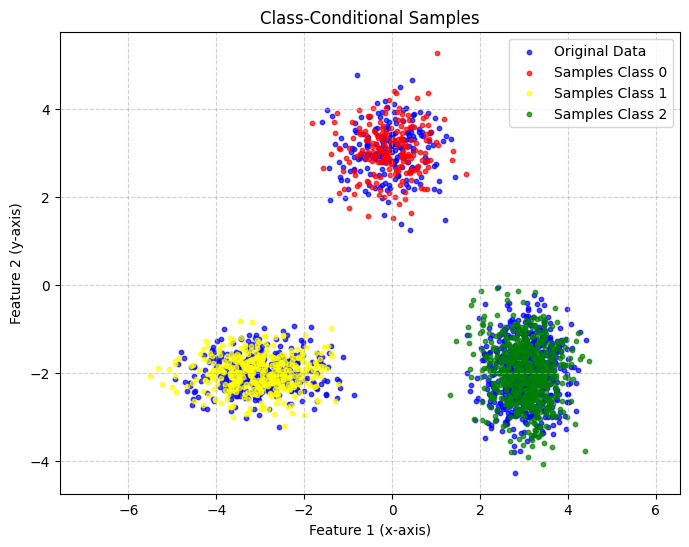

In [46]:
from spflow.utils.sampling_context import SamplingContext

out_features = rat.out_shape.features
num_features = 2

evidence = torch.full((200, num_features), torch.nan)
channel_index = torch.full((200, out_features), 0, dtype=torch.int64)
mask = torch.full((200, out_features), True, dtype=torch.bool)
sampling_ctx = SamplingContext(channel_index=channel_index, mask=mask)
samples_class0 = rat_class.root_node.inputs.sample(data=evidence, sampling_ctx=sampling_ctx)

evidence = torch.full((400, num_features), torch.nan)
channel_index = torch.full((400, out_features), 1, dtype=torch.int64)
mask = torch.full((400, out_features), True, dtype=torch.bool)
sampling_ctx = SamplingContext(channel_index=channel_index, mask=mask)
samples_class1 = rat_class.sample(data=evidence, sampling_ctx=sampling_ctx)

evidence = torch.full((600, num_features), torch.nan)
channel_index = torch.full((600, out_features), 2, dtype=torch.int64)
mask = torch.full((600, out_features), True, dtype=torch.bool)
sampling_ctx = SamplingContext(channel_index=channel_index, mask=mask)
samples_class2 = rat_class.sample(data=evidence, sampling_ctx=sampling_ctx)

plot_scatter([data_np, samples_class0, samples_class1, samples_class2], title='Class-Conditional Samples',
             label_list=['Original Data', 'Samples Class 0', 'Samples Class 1', 'Samples Class 2'])

However, the model can of course also be used for classification. As an example, we visualize the trained decision boundaries of our model

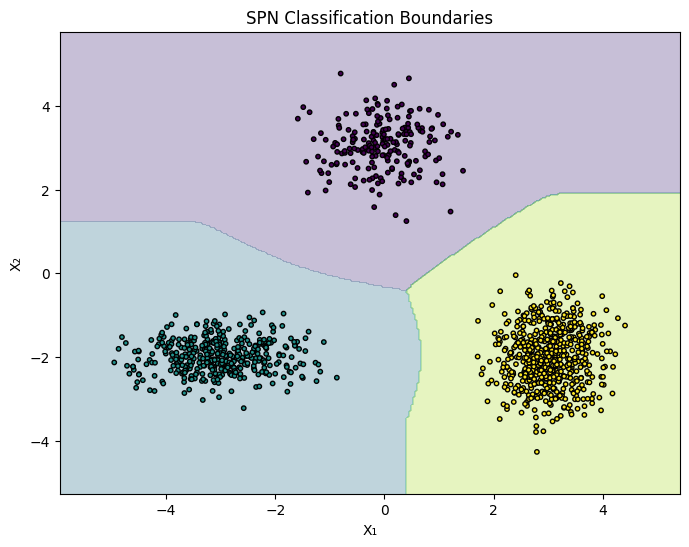

In [47]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# --- Assuming your dataset and labels are already created as above ---

# Let's assume you have an SPN model trained on this data:
# For example:
# spn = MySPNModel()
# spn.fit(dataset, labels)

# --- 1. Create a grid of points over the feature space ---
x_min, x_max = dataset[:, 0].min() - 1, dataset[:, 0].max() + 1
y_min, y_max = dataset[:, 1].min() - 1, dataset[:, 1].max() + 1

xx, yy = torch.meshgrid(
    torch.linspace(x_min, x_max, 300),
    torch.linspace(y_min, y_max, 300),
    indexing='xy'
)
grid_points = torch.stack([xx.flatten(), yy.flatten()], dim=1)

# --- 2. Get SPN predictions (probabilities or class scores) ---
# Example: if your SPN returns class probabilities
with torch.no_grad():
    probs = rat_class.log_posterior(grid_points)  # shape: [N_grid, num_classes]
    preds = probs.argmax(dim=-1)

# --- 3. Reshape predictions to match the grid ---
Z = preds.reshape(xx.shape)

# --- 4. Plot decision boundaries ---
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.3, levels=len(means), cmap="viridis")

# Plot the original data
plt.scatter(dataset[:, 0], dataset[:, 1], c=labels, cmap="viridis", s=10, edgecolor="k")

plt.title("SPN Classification Boundaries")
plt.xlabel("X₁")
plt.ylabel("X₂")
plt.show()


## LearnSPN
Instead of creating a random structure, we can also train the SPN structure using the LearnSPN. 

In [48]:
from spflow.learn.learn_spn import learn_spn

scope = Scope(list(range(2)))
normal_layer = Normal(scope=scope, out_channels=4)
learn_spn = learn_spn(
    torch.tensor(dataset, dtype=torch.float32),
    leaf_modules=normal_layer,
    out_channels=1,
    min_instances_slice=70,
    min_features_slice=2
)
learn_spn

used 8 iterations (0.0021s) to cluster 1200 items into 2 clusters
used 4 iterations (0.0004s) to cluster 797 items into 2 clusters


/var/folders/t3/57fhyt955l9d7dby5dmlzs900000gn/T/ipykernel_65171/568267606.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(dataset, dtype=torch.float32),


Sum(
  D=1, C=1, R=1, weights=(1, 5, 1, 1)
  (inputs): Cat(
    D=1, C=5, R=1, dim=2
    (inputs): ModuleList(
      (0): Sum(
        D=1, C=1, R=1, weights=(1, 8, 1, 1)
        (inputs): Cat(
          D=1, C=8, R=1, dim=2
          (inputs): ModuleList(
            (0-1): 2 x Product(
              D=1, C=4, R=1
              (inputs): Cat(
                D=2, C=4, R=1, dim=1
                (inputs): ModuleList(
                  (0-1): 2 x Normal(D=1, C=4, R=1)
                )
              )
            )
          )
        )
      )
      (1): Product(
        D=1, C=4, R=1
        (inputs): Cat(
          D=2, C=4, R=1, dim=1
          (inputs): ModuleList(
            (0-1): 2 x Normal(D=1, C=4, R=1)
          )
        )
      )
    )
  )
)

The trained SPN can now be used just like any other module

2
(1200, 2)
Original Data
2
torch.Size([1500, 2])
Samples


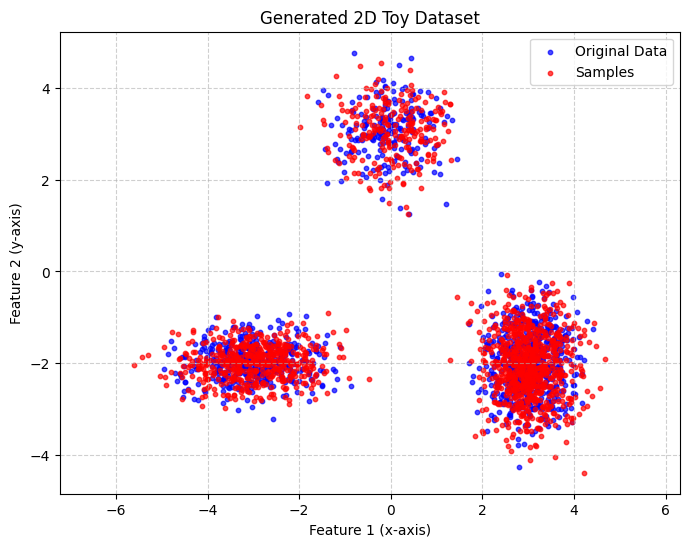

In [49]:
learn_spn_samples = spn.sample(num_samples=1500)

plot_scatter([data_np, samples], title='Generated 2D Toy Dataset', label_list=['Original Data', 'Samples'])

## Advanced Queries

To showcase more advanced queries like conditional sampling and MPE (Most Probable Explanation) we take a look at a dataset with more features.
Below, we load the digits dataset. This dataset contains 1797 8x8 images of digits 0 to 9.

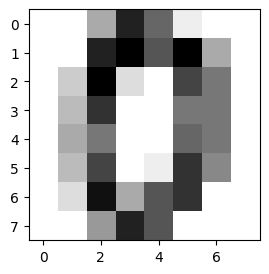

torch.Size([1797, 64])
tensor(0.) tensor(16.)


In [50]:
import matplotlib.pyplot as plt

from sklearn import datasets

# Load the digits dataset
digits = datasets.load_digits()

# Display the last digit
plt.figure(1, figsize=(3, 3))
plt.imshow(digits.images[0], cmap=plt.cm.gray_r, interpolation="nearest")
plt.show()

X = digits.data  # shape (1797, 64)
y = digits.target  # shape (1797,)

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

print(X_tensor.shape)
print(X_tensor.min(), X_tensor.max())

Again we create a Rat SPN, but this time we use a Binomial distribution for the leaf layer. 

In [51]:
from spflow.modules.leaves import Binomial

depth = 3
n_region_nodes = 5
num_leaves = 5
num_repetitions = 2
n_root_nodes = 1
num_feature = 64
n = torch.tensor(16)  # total count for binomial distribution

scope = Scope(list(range(0, num_feature)))

rat_leaf_layer = Binomial(scope=scope, total_count=n, out_channels=num_leaves, num_repetitions=num_repetitions)
rat = RatSPN(
    leaf_modules=[rat_leaf_layer],
    n_root_nodes=n_root_nodes,
    n_region_nodes=n_region_nodes,
    num_repetitions=num_repetitions,
    depth=depth,
    outer_product=True,
    split_mode=SplitMode.consecutive(),
)
print(rat.to_str())

RatSPN [D=1, C=1, R=2] → scope: 0-63
└─ RepetitionMixingLayer [D=1, C=1] [weights: (1, 1, 2)] → scope: 0-63
   └─ Sum [D=1, C=1] [weights: (1, 25, 1, 2)] → scope: 0-63
      └─ OuterProduct [D=1, C=25] → scope: 0-63
         └─ SplitConsecutive [D=2, C=5] → scope: 0-63
            └─ Sum [D=2, C=5] [weights: (2, 25, 5, 2)] → scope: 0-63
               └─ OuterProduct [D=2, C=25] → scope: 0-63
                  └─ SplitConsecutive [D=4, C=5] → scope: 0-63
                     └─ Sum [D=4, C=5] [weights: (4, 25, 5, 2)] → scope: 0-63
                        └─ OuterProduct [D=4, C=25] → scope: 0-63
                           └─ SplitConsecutive [D=8, C=5] → scope: 0-63
                              └─ Factorize [D=8, C=5] → scope: 0-63
                                 └─ Binomial [D=64, C=5] → scope: 0-63


In [52]:
train_gradient_descent(rat, dataloader, epochs=20, lr=0.1)

Below is a visualization of some samples drawn from the Spn

torch.Size([5, 64])


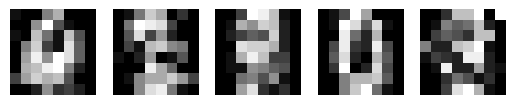

In [53]:
samples = rat.sample(num_samples=5)
print(samples.shape)

for i in range(5):
    img = samples[i].reshape(8, 8)  # reshape back to 2D
    plt.subplot(1, 5, i + 1)
    plt.imshow(img, cmap="gray")
    plt.axis("off")
plt.show()

Now can show some more advanced queries. One of them is getting the MPE. It returns the most probable state of the probabilistic circuit. This is often helpful to generate more clear samples and a good indicator whether the model could learn the data or not, which is not always evident with regular samples.

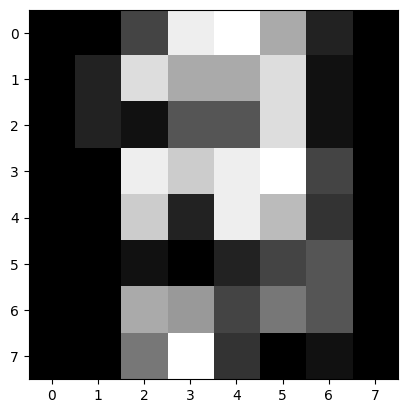

In [54]:
mpe = rat.sample(num_samples=1, is_mpe=True)
plt.imshow(mpe.reshape(8, 8), cmap="gray")
plt.show()

And at last we want to sample, given some evidence. In this example, the lower half of the image is given, and we want to sample the upper half given the lower half. 
This time, instead of explicitly defining a sampling context, we use the sample_with_evidence method. The method allows the user to just input the evidence and let the library internally handle the creation of the sampling context. This becomes handy if you have evidence but not multiple channel to sample from.

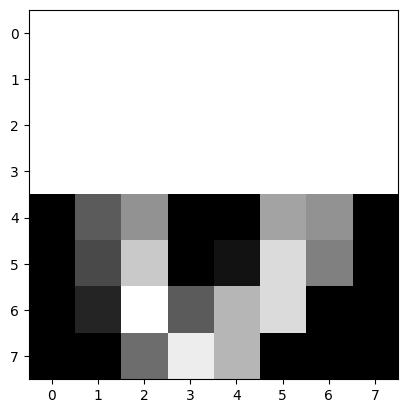

torch.Size([1, 64])


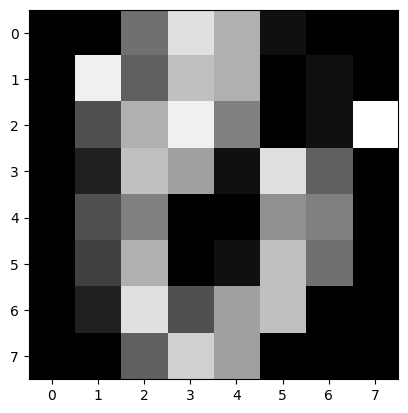

In [55]:
evidence = X_tensor[0]
evidence[:32] = torch.nan
plt.imshow(evidence.reshape(8, 8), cmap="gray")
plt.show()
evidence = evidence.unsqueeze(0)
print(evidence.shape)
samples = rat.sample_with_evidence(evidence=evidence)
plt.imshow(samples.reshape(8, 8), cmap="gray")
plt.show()
